I have created 3 tables, customer table containing customer details, product table containing product details and transaction table containing transaction detail.For further details I have enclosed the csv files in the main folder.I did analysis and finally ploted few charts

In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=aa625e93e2c86a81fae545c4cd3f1ff954591b9b7ce89bc89956dfba795f2734
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import  Window
import pyspark.sql.types as T
from pyspark.sql.functions import unix_timestamp, from_unixtime


In [ ]:
spark = SparkSession.builder.getOrCreate()

Reading Transaction csv file

In [ ]:
df = spark.read.csv('/content/Transaction.csv', inferSchema = True , header=True)

In [ ]:
df.show(5)

+----------+-------------+----------+---------+--------------------+------------+--------+----------+
|CustomerID|TransactionNo|      Date|ProductNo|             product|market_price|Quantity|CustomerNo|
+----------+-------------+----------+---------+--------------------+------------+--------+----------+
|         1|       581482|01-01-2021|    22485|Garlic Oil - Vege...|       220.0|      12|     17490|
|         2|       581475|04-01-2021|    22596|Water Bottle - Or...|       180.0|      36|     13069|
|         2|       581475|05-01-2021|    23235|Brass Angle Deep ...|       250.0|      12|     13069|
|         2|       581475|06-01-2021|    23272|Cereal Flip Lid C...|       176.0|      12|     13069|
|         2|       581475|07-01-2021|    23239|Creme Soft Soap -...|       162.0|       6|     13069|
+----------+-------------+----------+---------+--------------------+------------+--------+----------+
only showing top 5 rows



Dividing the DataFrame into groups or partitions based on the values in the 'CustomerID' column. Each partition will have its own frame of data for calculations and we are ordering by date

In [ ]:
windowSpec = Window.partitionBy('CustomerID').orderBy(F.col('Date'))

Creating 3 columns list_price, average_price, total_price. List price contains product price of each partion in chronological order

In [ ]:
data1 = df.withColumn('list_price', F.collect_list(F.col('market_price')).over(windowSpec)).withColumn('average_price', F.avg(F.col('market_price')) \
.over(windowSpec)).withColumn('total_price', F.sum(F.col('market_price')).over(windowSpec))

Converting date column in data1 dataframe from string to date format

In [ ]:
data1 = data1.withColumn("Date", F.to_date(F.col("Date"), "dd-MM-yyyy"))

In [110]:
data1.show(10)

+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+
|CustomerID|TransactionNo|      Date|ProductNo|             product|market_price|Quantity|CustomerNo|          list_price|     average_price|total_price|
+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+
|         1|       581482|2021-01-01|    22485|Garlic Oil - Vege...|       220.0|      12|     17490|             [220.0]|             220.0|      220.0|
|         2|       581475|2021-01-04|    22596|Water Bottle - Or...|       180.0|      36|     13069|             [180.0]|             180.0|      180.0|
|         2|       581475|2021-01-05|    23235|Brass Angle Deep ...|       250.0|      12|     13069|      [180.0, 250.0]|             215.0|      430.0|
|         2|       581475|2021-01-06|    23272|Cereal Flip Lid C...|       1

Moving average column represents the moving average of 'average_price' for each 'CustomerID' within the window defined by 'CustomerID' and ordered by 'Date'. The moving average is calculated based on the average of 'average_price' of preceding rows (within the window) for each customer

In [ ]:
data2 = data1.withColumn('moving_avg_price', F.avg('average_price').over(windowSpec))

**To determine whether the customer has shifted from higher to lower value products**

 we are comparing current moving average price with preceding moving average price.If current moving average price < preceding moving average price we are using it means there is Downward Substitution

In [ ]:

data2 = data2.withColumn('shifted_to_lower_value',
                         F.when(F.lag('moving_avg_price').over(windowSpec) > F.col('moving_avg_price'), True)
                         .otherwise(False))

In [ ]:
# Filter the DataFrame to get customers who have shifted to lower value products
result_df = data2.filter((F.col('shifted_to_lower_value') == True))


In [ ]:
result_df.show(10)

+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+
|CustomerID|TransactionNo|      Date|ProductNo|             product|market_price|Quantity|CustomerNo|          list_price|     average_price|total_price|  moving_avg_price|shifted_to_lower_value|
+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+
|         2|       581475|2021-01-07|    23239|Creme Soft Soap -...|       162.0|       6|     13069|[180.0, 250.0, 17...|             192.0|      768.0|            197.25|                  true|
|         2|       581475|2021-01-08|    21705|Germ - Removal Mu...|       199.0|      24|     13069|[180.0, 250.0, 17...|             193.4|      967.0|            196.48|                  true|
|         2|       5

Out of total 2000 transaction we ave 570 transactions where we encountered downward substitution

In [ ]:
result_df.count()

570

counting occurance of downward substitution customers

In [111]:
# Grouping the DataFrame by 'CustomerID' and count the occurrences of each customer
result_count_df = result_df.groupBy('CustomerID').agg(F.count(F.lit(1)).alias('Shift_Count'))

# Order the result in descending order based on the 'Shift_Count'
result_count_df = result_count_df.orderBy(F.desc('Shift_Count'))

result_count_df.show(5)

+----------+-----------+
|CustomerID|Shift_Count|
+----------+-----------+
|        25|         80|
|        23|         68|
|        49|         65|
|        17|         52|
|        51|         42|
+----------+-----------+
only showing top 5 rows



Out of 55 customers we have 39 downward substitution customers

In [ ]:
result_count_df.count()

39

In [ ]:

product_df = spark.read.csv('/content/Product.csv', inferSchema = True , header=True)
product_df.show(5)

+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|ProductNo|            category|        sub_category|             product|            brand|market_price|rating|
+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|    22485|    Beauty & Hygiene|           Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|
|    22596|Kitchen, Garden &...|Storage & Accesso...|Water Bottle - Or...|       Mastercook|       180.0|   2.3|
|    23235|Cleaning & Household|         Pooja Needs|Brass Angle Deep ...|              Trm|       250.0|   3.4|
|    23272|Cleaning & Household|Bins & Bathroom Ware|Cereal Flip Lid C...|           Nakoda|       176.0|   3.7|
|    23239|    Beauty & Hygiene|    Bath & Hand Wash|Creme Soft Soap -...|            Nivea|       162.0|   4.4|
+---------+--------------------+--------------------+--------------------+-----------------+----

To find all the product categories that are showing downward substitution we are going to join the result_df with the product table

In [ ]:
merged_df = result_df.join(product_df, on='ProductNo', how='inner')


In [ ]:
merged_df.show(5)

+---------+----------+-------------+----------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+--------------------+--------------------+--------------------+--------------+------------+------+
|ProductNo|CustomerID|TransactionNo|      Date|             product|market_price|Quantity|CustomerNo|          list_price|     average_price|total_price|  moving_avg_price|shifted_to_lower_value|            category|        sub_category|             product|         brand|market_price|rating|
+---------+----------+-------------+----------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+--------------------+--------------------+--------------------+--------------+------------+------+
|    23239|         2|       581475|2021-01-07|Creme Soft Soap -...|       162.0|       6|     13069|[180.0, 250.0, 17

Counting categories which have shown downward substitution

In [ ]:
# Grouping by 'product_category' and counting the occurrences
category_counts = merged_df.groupBy('category').count()


In [ ]:
category_counts.count()

11

Arranged the categories which shown maximum downward substitution in descending order

In [ ]:
category_counts = category_counts.orderBy(F.desc('count'))
category_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|    Beauty & Hygiene|  377|
|Gourmet & World Food|  259|
|Foodgrains, Oil &...|  171|
|Kitchen, Garden &...|  165|
|Snacks & Branded ...|  146|
|Cleaning & Household|  137|
|Bakery, Cakes & D...|   51|
| Fruits & Vegetables|   35|
|           Beverages|   30|
|   Eggs, Meat & Fish|   28|
|           Baby Care|   21|
+--------------------+-----+



reading customer table.

In [ ]:
customer_df = spark.read.csv('/content/Customers.csv', inferSchema = True , header=True)

In [ ]:
customer_df.show(5)

+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
|CustomerID|      Name|Gender|Age|   Profession|Work Experience|Family Size|Annual Income|  City|
+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
|         1|Muhammad+1|  Male| 19|   Healthcare|              1|          4|? 5,43,000.00|Mumbai|
|         2|       Sai|  Male| 21|     Engineer|              3|          3|? 6,74,000.00|Mumbai|
|         3|     Advik|Female| 20|     Engineer|              1|          1|? 8,25,000.00|Nagpur|
|         4|     Rudra|Female| 23|       Lawyer|              0|          2|? 5,12,000.00|  Pune|
|         5|   Aayansh|Female| 31|Entertainment|              2|          6|? 7,25,000.00|  Pune|
+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
only showing top 5 rows



Inner joining result_df and customer table to get the details of all the customers who have shown downward substitution

In [ ]:
merged_df2 = result_df.join(customer_df, on='CustomerID', how='inner')

In [ ]:
merged_df2.show(5)

+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+-----+------+---+----------+---------------+-----------+-------------+------+
|CustomerID|TransactionNo|      Date|ProductNo|             product|market_price|Quantity|CustomerNo|          list_price|     average_price|total_price|  moving_avg_price|shifted_to_lower_value| Name|Gender|Age|Profession|Work Experience|Family Size|Annual Income|  City|
+----------+-------------+----------+---------+--------------------+------------+--------+----------+--------------------+------------------+-----------+------------------+----------------------+-----+------+---+----------+---------------+-----------+-------------+------+
|         2|       581475|2021-01-07|    23239|Creme Soft Soap -...|       162.0|       6|     13069|[180.0, 250.0, 17...|             192.0|      768.0|            197.25|         

In [ ]:
unique_customer_ids = merged_df2.select('CustomerID').distinct()

In [ ]:
# Out of 55 Customers 39 Customers Showed Downward Substitution
unique_customer_ids.count()

39

Perform an inner join on 'CustomerID' column between customer table and unique_customer_ids

In [ ]:

joined_df = customer_df.join(unique_customer_ids, on='CustomerID', how='inner')


joined_df.show(5)

+----------+-------+------+---+-------------+---------------+-----------+-------------+------+
|CustomerID|   Name|Gender|Age|   Profession|Work Experience|Family Size|Annual Income|  City|
+----------+-------+------+---+-------------+---------------+-----------+-------------+------+
|         2|    Sai|  Male| 21|     Engineer|              3|          3|? 6,74,000.00|Mumbai|
|         3|  Advik|Female| 20|     Engineer|              1|          1|? 8,25,000.00|Nagpur|
|         4|  Rudra|Female| 23|       Lawyer|              0|          2|? 5,12,000.00|  Pune|
|         5|Aayansh|Female| 31|Entertainment|              2|          6|? 7,25,000.00|  Pune|
|         8|   Veer|Female| 23|   Healthcare|              1|          3|? 7,89,000.00|  Pune|
+----------+-------+------+---+-------------+---------------+-----------+-------------+------+
only showing top 5 rows



For plotting the graphs I'm using Pandas to convert pyspark dataframe to pandas data frame

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pd_category_counts = category_counts.toPandas()

In [ ]:
pd_category_counts.head(3)

,category,count
0,Beauty & Hygiene,377
1,Gourmet & World Food,259
2,"Foodgrains, Oil & Masala",171


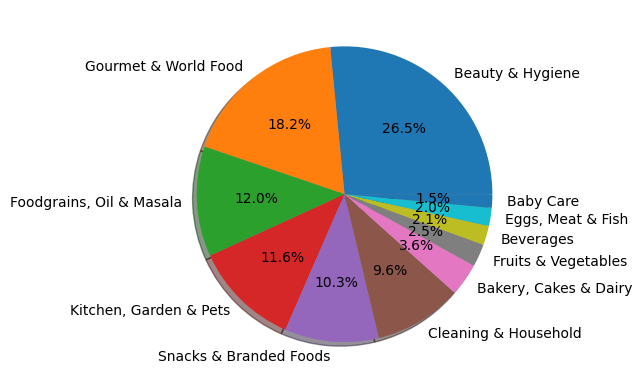

In [ ]:
plt.pie(pd_category_counts['count'],labels = pd_category_counts['category'],autopct = '%0.1f%%', shadow=True )
plt.show()

**Above chart shows Downwards Substitution per Category**

In [ ]:
pd_merged_df = merged_df.toPandas()
pd_merged_df.head(2)

,ProductNo,CustomerID,TransactionNo,Date,product,market_price,Quantity,CustomerNo,list_price,average_price,total_price,moving_avg_price,shifted_to_lower_value,category,sub_category,product,brand,market_price,rating
0,23239,2,581475,2021-01-07,Creme Soft Soap - For Hands & Body,162.0,6,13069,"[180.0, 250.0, 176.0, 162.0]",192.0,768.0,197.25,True,Beauty & Hygiene,Bath & Hand Wash,Creme Soft Soap - For Hands & Body,Nivea,162.0,4.4
1,21705,2,581475,2021-01-08,Germ - Removal Multipurpose Wipes,199.0,24,13069,"[180.0, 250.0, 176.0, 162.0, 199.0]",193.4,967.0,196.48,True,Cleaning & Household,All Purpose Cleaners,Germ - Removal Multipurpose Wipes,Nature Protect,199.0,3.3


**Top 10 brands that where people showed downward substitution**


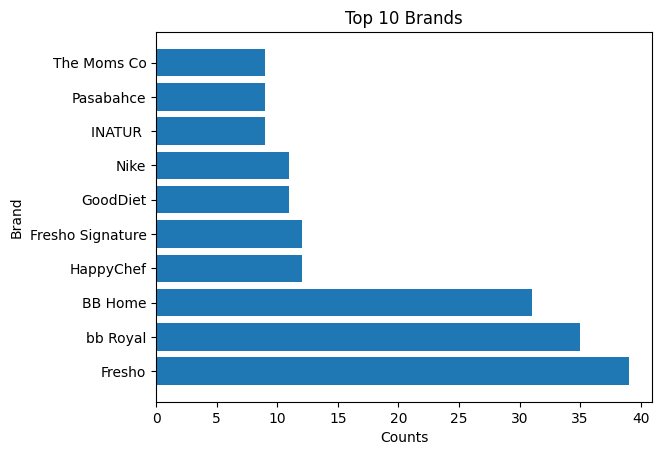

In [ ]:
top_brands = pd_merged_df['brand'].value_counts(ascending = False).head(10)
plt.barh(top_brands.index, top_brands.values)

plt.xlabel('Counts')
plt.ylabel('Brand')
plt.title('Top 10 Brands')



plt.show()

**Top 10 Brands where people showed less interest**

In [ ]:
type(joined_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
pd_joined_df = joined_df.toPandas()
pd_joined_df.head(3)

,CustomerID,Name,Gender,Age,Profession,Work Experience,Family Size,Annual Income,City
0,2,Sai,Male,21,Engineer,3,3,"? 6,74,000.00",Mumbai
1,3,Advik,Female,20,Engineer,1,1,"? 8,25,000.00",Nagpur
2,4,Rudra,Female,23,Lawyer,0,2,"? 5,12,000.00",Pune


25 women and 14 men showed this behaviour

In [ ]:
pd_joined_df['Gender'].value_counts()

Female    25
Male      14
Name: Gender, dtype: int64

Text(0, 0.5, 'Counts')

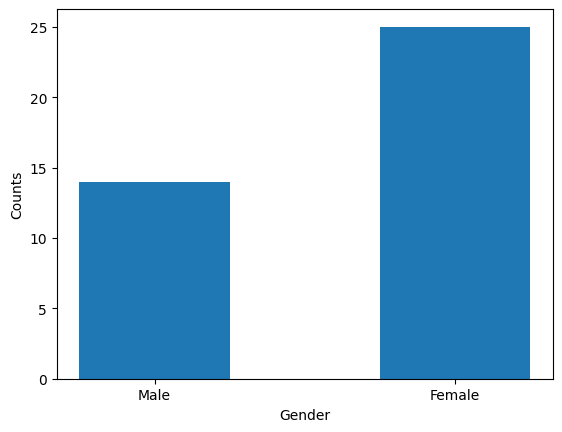

In [ ]:
count = [14,25]
gender = ['Male','Female']
plt.bar(gender,count,width = 0.5)
plt.xlabel('Gender')
plt.ylabel('Counts')

Above chart shows downward substitution per gender

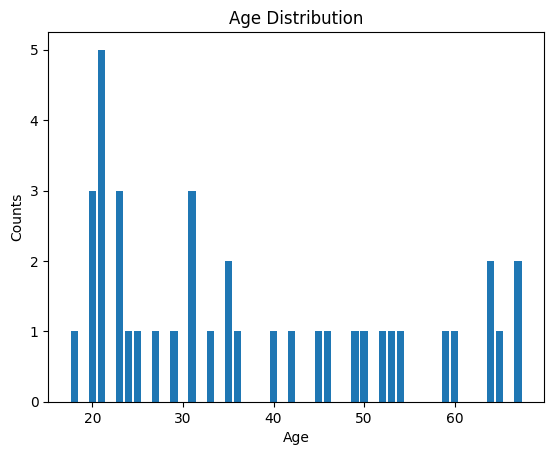

In [ ]:
a = pd_joined_df['Age'].unique()
b = pd_joined_df['Age'].value_counts()

# Create a bar plot
plt.bar(a, b)

plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Age Distribution')

plt.show()

Age distribution of people who showed Downward substitution

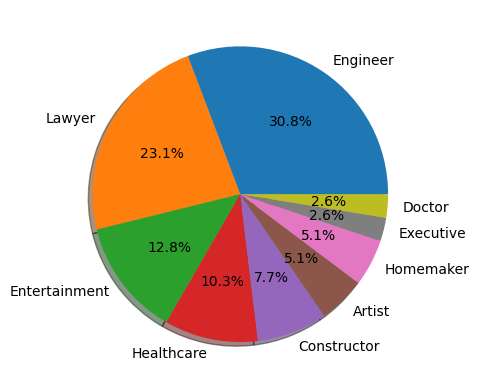

In [ ]:
plt.pie(pd_joined_df['Profession'].value_counts(ascending=False), labels =pd_joined_df['Profession'].unique(),autopct = '%0.1f%%', shadow=True)
plt.show()

Above pie chart shows Engineers,Lawyers,Entertainment professionals are top people who showed downward substitution

Text(0.5, 1.0, 'Downward Substitution by City')

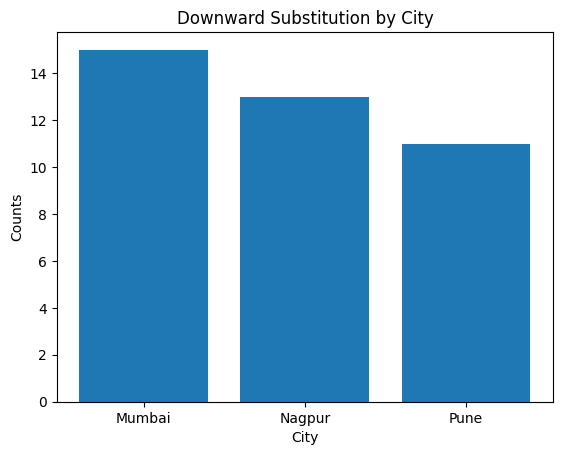

In [ ]:
y = pd_joined_df['City'].value_counts().values.tolist()
x = pd_joined_df['City'].unique().tolist()
plt.bar(x,y)
plt.xlabel('City')
plt.ylabel('Counts')
plt.title('Downward Substitution by City')